In [2]:
!pip install -q wget
import wget
import os
import zipfile

  Preparing metadata (setup.py) ... done


In [3]:
from torchvision.datasets import VOCDetection as TVVOCDetection


In [4]:
import torch
from torch.utils.data import Dataset
from torchvision.datasets import VOCDetection
from torchvision import transforms
from PIL import Image
from torch.utils.data import DataLoader
import torchvision.models as models
import torch.nn as nn

# Load Date


In [11]:
if not os.path.exists('VOCdevkit/VOC2007'):
    url = 'http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar'
    filename = wget.download(url)
    !mkdir VOCdevkit
    !tar -xf VOCtrainval_06-Nov-2007.tar -C VOCdevkit
    !rm VOCtrainval_06-Nov-2007.tar


# Prepare the data

In [6]:
VOC_CLASSES = [ "aeroplane", "bicycle", "bird", "boat", "bottle",
    "bus", "car", "cat", "chair", "cow", "diningtable",
    "dog", "horse", "motorbike", "person", "pottedplant",
    "sheep", "sofa", "train", "tvmonitor"]

In [ ]:
class VOCDetection_dataset(Dataset):
   def __init__(self, root, year='2007', image_set='trainval', download=False, transform=None, target_transform=None, transforms=None):
      self.dataset = TVVOCDetection(root=root, year=year, image_set=image_set, download=False)
      self.transform = transform
      self.classes = VOC_CLASSES
      self.num_classes = len(self.classes)



   def __len__(self):
     return len(self.dataset)



   def __getitem__(self , index):
      image , target = self.dataset[index]

      image = image.convert("RGB")

      if self.transform:
         image = self.transform(image)

      labels = self.extract_multilabel(target)

      return image , torch.tensor(labels , dtype = torch.float32)



   def extract_multilabel(self, target):
        objects = target['annotation'].get('object', [])
        labels = [0] * len(self.classes)

        if not isinstance(objects, list):
            objects = [objects]

        for obj in objects:
            class_name = obj['name']
            if class_name in self.classes:
                idx = self.classes.index(class_name)
                labels[idx] = 1

        return labels
     

In [ ]:
transform = transforms.Compose([transforms.Resize((224,224)) , transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])


In [ ]:
train_dataset = VOCDetection_dataset(root = 'VOCdevkit'
       , year = '2007'
       , image_set = 'train'
       , transform = transform
      )
#dataloader
train_loader = DataLoader(train_dataset , batch_size = 16   ,  shuffle = True , )


In [15]:
val_dataset = VOCDetection_dataset(root='VOCdevkit',
                                   year='2007',
                                   image_set='val',
                                   transform=transform)

val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)


In [ ]:
img, labels = train_dataset[938]
print(img.shape)
print(labels)


torch.Size([3, 224, 224])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0.])


#  Transfer Learning Model (ResNet50)

In [ ]:
class CustomResNet(nn.Module):
    def __init__(self, num_classes):
        super(CustomResNet, self).__init__()
        self.base_model = models.resnet50(pretrained=True)
        for param in self.base_model.parameters():
            param.requires_grad = False
        num_ftrs = self.base_model.fc.in_features
        self.base_model.fc = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        x = self.base_model(x)
        x = torch.sigmoid(x)
        return x
    

In [48]:
model = CustomResNet(num_classes=len(VOC_CLASSES))


# training

In [49]:
#EarlyStopping
class EarlyStopping():
  def __init__(self , patience = 3 , min_delta = 0) :
    self.patience = patience
    self.min_delta = min_delta
    self.counter = 0
    self.best_loss = float("inf")
    self.early_stop = False
    self.best_model_state = None
  def __call__(self , val_loss , model): # Added val_loss parameter
    if val_loss < self.best_loss - self.min_delta:
      self.best_loss = val_loss
      self.counter = 0
      self.best_model_state = model.state_dict()
    else:
      self.counter +=1
      if self.counter >= self.patience:
        self.early_stop = True



In [50]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

CustomResNet(
  (base_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
  

In [51]:
# loss function
criterion = nn.BCELoss()
 #optimizer
optimizer = torch.optim.Adam(model.base_model.fc.parameters(), lr = 0.001)


#early_sopping
early_stopping = EarlyStopping(patience = 3 , min_delta = 0.01)
epochs = 30

In [52]:
#training loop
for epoch in range(epochs):
    model.train()
    loss_training = 0.0
    for images ,labels in train_loader :
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)

        loss = criterion(outputs ,labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_training += loss.item()
    avg_train_loss  = loss_training / len(train_loader)

    #val

    model.eval()
    val_loss = 0.0

    with torch.no_grad():
      for images , labels in val_loader :

         images = images.to(device)
         labels = labels.to(device)

         outputs = model(images)
         loss = criterion(outputs, labels)
         val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)

    print(f"Epoch {epoch+1} , Training loss: {avg_train_loss:.4f} , validation loss: {avg_val_loss:.4f}")

    early_stopping(avg_val_loss, model)
    if early_stopping.early_stop:
        print("early stopping triggered")
        break












Epoch 1 , Training loss: 0.1777 , validation loss: 0.1147
Epoch 2 , Training loss: 0.1144 , validation loss: 0.1025
Epoch 3 , Training loss: 0.0997 , validation loss: 0.0963
Epoch 4 , Training loss: 0.0937 , validation loss: 0.0912
Epoch 5 , Training loss: 0.0891 , validation loss: 0.0893
Epoch 6 , Training loss: 0.0851 , validation loss: 0.0919
Epoch 7 , Training loss: 0.0825 , validation loss: 0.0929
early stopping triggered


In [53]:

correct_predictions = 0
total_predictions = 0

model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)

        predicted_labels = (outputs > 0.5).float()

        correct_predictions += (predicted_labels == labels).sum().item()
        total_predictions += labels.numel()

accuracy = 100 * correct_predictions / total_predictions
print(f"Validation Accuracy: {accuracy:.2f}%")


Validation Accuracy: 96.75%


In [ ]:
import matplotlib.pyplot as plt

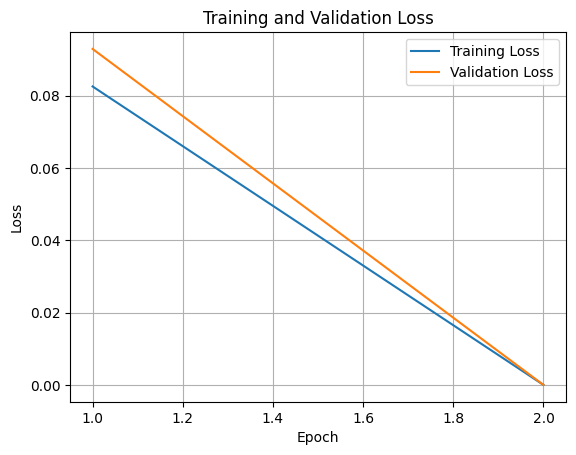

In [64]:
train_losses = [avg_train_loss]
val_losses = [avg_val_loss]

train_losses.append(0.0)
val_losses.append(0.0)


epochs = range(1, len(train_losses) + 1)

plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


In [65]:
torch.save(early_stopping.best_model_state, 'best_model.pth')

# Load the best model state for deployment
best_model = CustomResNet(num_classes=len(VOC_CLASSES))
best_model.load_state_dict(torch.load('best_model.pth'))
best_model.to(device)
best_model.eval()


CustomResNet(
  (base_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
  